
## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [5]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif ,VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [6]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# ToDo: Define base models (Decision Tree, kNN, Logistic Regression)

# Decision Tree hyperparameters
param_grid_dt = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

# k-Nearest Neighbors hyperparameters
param_grid_knn = {
    "classifier__n_neighbors": [3, 5, 7, 11],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan"]
}

# Logistic Regression hyperparameters
param_grid_lr = {
    "classifier__penalty": ["l2"],   # "l1" also possible if solver='liblinear' or 'saga'
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["liblinear", "lbfgs"],
    "classifier__max_iter": [100, 500]
}
# ToDo: Create a list of (classifier, param_grid, name) tuples
# Create list of (classifier, param_grid, name) tuples
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "DecisionTree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(random_state=42), param_grid_lr, "LogisticRegression")
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [7]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [8]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    selector = VarianceThreshold(threshold=0)
    selector.fit(X)
    X = X[X.columns[selector.get_support(indices=True)]]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [9]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [10]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [11]:
def run_manual_grid_search(X_train, y_train, dataset_name, classifiers_to_tune):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # TODO: Implement manual grid search for hyperparameter tuning.
        # Steps to implement:
        # 1. Adjust the feature selection parameter grid to ensure 'k' does not exceed the number of features.
        if 'feature_selection__k' in param_grid:
            param_grid['feature_selection__k'] = [min(k, n_features) for k in param_grid['feature_selection__k']]

        # 2. Generate all combinations of hyperparameters from the adjusted parameter grid.
        keys, values = zip(*param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        # 3. For each parameter combination:
        for params in param_combinations:
            fold_scores = []

            #    a. Perform cross-validation (e.g., 5-fold StratifiedKFold).
            for train_idx, val_idx in cv.split(X_train, y_train):
                #       i. Split the training data into training and validation sets.
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                #       ii. Build a pipeline with scaling, feature selection, and the classifier.
                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif,k='all')),
                    ('classifier', classifier_instance)
                ])

                #       iii. Set the pipeline parameters for the current combination.
                pipeline.set_params(**params)

                #       iv. Fit the pipeline on the training fold.
                pipeline.fit(X_tr, y_tr)

                #       v. Predict probabilities on the validation fold.
                y_pred_proba = pipeline.predict_proba(X_val)[:, 1]  # probability of positive class

                #       vi. Compute the AUC score for the fold.
                fold_auc = roc_auc_score(y_val, y_pred_proba)
                fold_scores.append(fold_auc)

            #    c. Compute the mean AUC across all folds for the parameter combination.
            mean_auc = np.mean(fold_scores)

            #    d. Track and print the best parameter combination and its mean AUC.
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        # Create the final pipeline for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif,k='all')),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found
        final_pipeline.set_params(**best_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators


**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [12]:
def run_builtin_grid_search(X_train, y_train, dataset_name, classifiers_to_tune):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # TODO: Implement built-in grid search for each classifier:
        # - Adjust feature selection parameter grid based on dataset size (n_features)
        if 'feature_selection__k' in param_grid:
            param_grid['feature_selection__k'] = [min(k, n_features) for k in param_grid['feature_selection__k']]

        # - Create a pipeline with StandardScaler, SelectKBest(f_classif), and the classifier
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif,k='all')),
            ('classifier', classifier_instance)
        ])

        # - Set up StratifiedKFold cross-validation
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # - Run GridSearchCV with the pipeline and adjusted param grid
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        # - Fit grid search on training data and collect best estimator/results
        grid_search.fit(X_train, y_train)

        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [13]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual", X_train=None, y_train=None):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [14]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    # Pass the classifiers_to_tune list defined at the start
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name, classifiers_to_tune)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name, classifiers_to_tune)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    # Optionally, pass X_train and y_train to evaluate_models for built-in voting
    builtin_votes, builtin_proba = evaluate_models(
        X_test, y_test, builtin_estimators, actual_name, "Built-in", X_train=X_train, y_train=y_train
    )

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for DecisionTree ---
------------------------------------------------------------------------------------------
Best parameters for DecisionTree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__criterion': 'gini'}
Best cross-validation AUC: 0.7705
--- Manual Grid Search for kNN ---
------------------------------------------------------------------------------------------
Best parameters for kNN: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}
Best cross-validation AUC: 0.8666
--- Manual Grid Sear

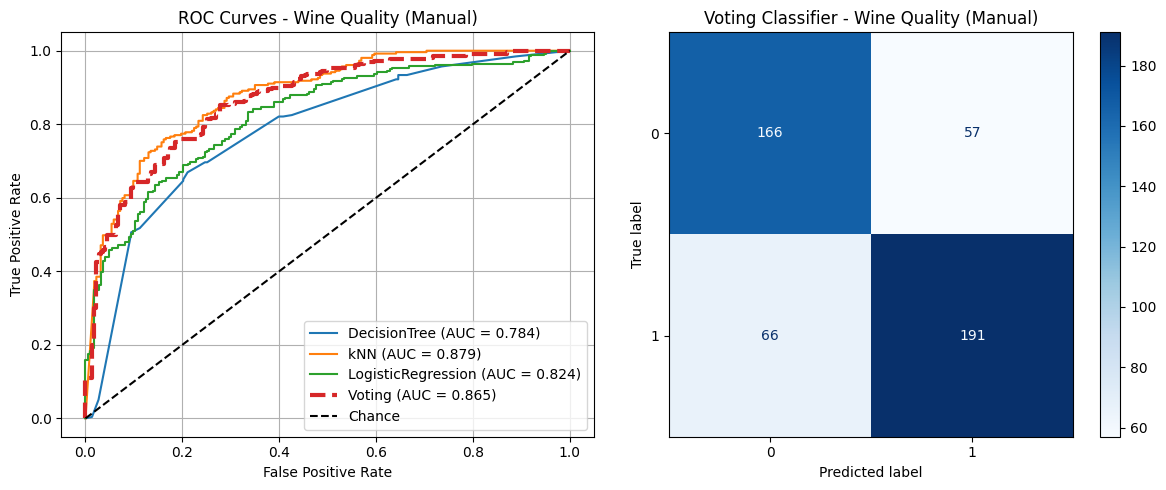


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for DecisionTree ---
Best params for DecisionTree: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 10}
Best CV score: 0.7705

--- GridSearchCV for kNN ---


c:\Users\aayan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params for kNN: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Best CV score: 0.8666

--- GridSearchCV for LogisticRegression ---
Best params for LogisticRegression: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.8052

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

--- Individual Model Performance ---

DecisionTree:
  Accuracy: 0.7229
  Precision: 0.7650
  Recall: 0.6965
  F1-Score: 0.7291
  ROC AUC: 0.7843

kNN:
  Accuracy: 0.7917
  Precision: 0.7918
  Recall: 0.8288
  F1-Score: 0.8099
  ROC AUC: 0.8791

LogisticRegression:
  Accuracy: 0.7333
  Precision: 0.7549
  Recall: 0.7432
  F1-Score: 0.7490
  ROC AUC: 0.8242

--- Built-in Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.7792, Precision: 0.7871
  Recall: 0.8054, F1: 0.7962, AUC: 0.8652


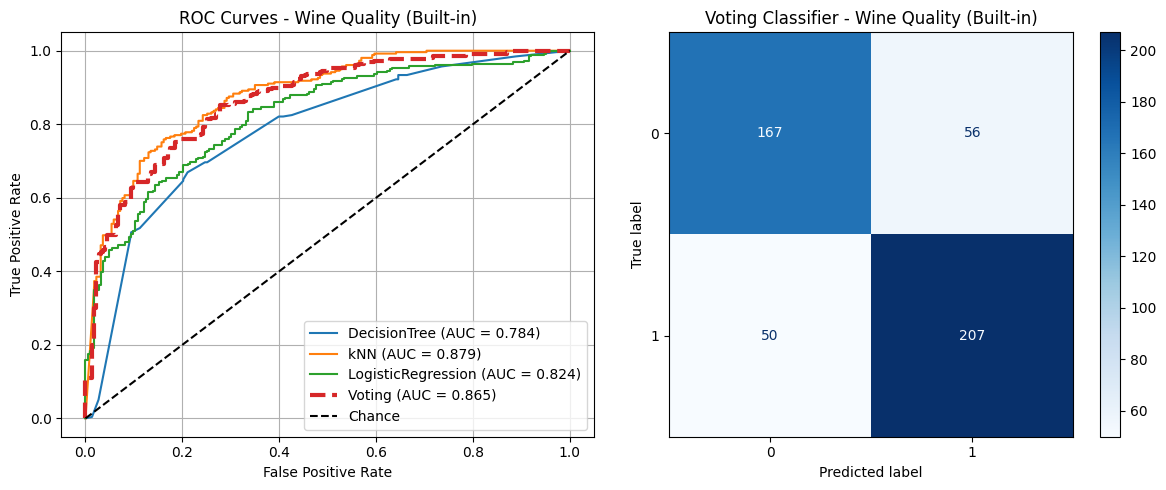


Completed processing for Wine Quality

ALL DATASETS PROCESSED!


In [15]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)